In [3]:
# imports
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.python.layers.core import Dropout

In [4]:
# import data
data = pd.read_csv("data.csv")

# EDA

In [5]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
data.dtypes

,0
Age,int64
Sex,object
ChestPainType,object
RestingBP,int64
Cholesterol,int64
FastingBS,int64
RestingECG,object
MaxHR,int64
ExerciseAngina,object
Oldpeak,float64


In [7]:
data.dtypes.isnull()

,0
Age,False
Sex,False
ChestPainType,False
RestingBP,False
Cholesterol,False
FastingBS,False
RestingECG,False
MaxHR,False
ExerciseAngina,False
Oldpeak,False


In [8]:
data.describe(include = "object")

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


In [9]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [10]:
data.duplicated(keep=False).value_counts()

,count
False,918


## Label Encoding

In [11]:
label_encoder = LabelEncoder()
categorical_encode = data.select_dtypes(include=['object']).columns.tolist()
for column in categorical_encode:
    data[column] = label_encoder.fit_transform(data[column].astype(str))
    print(f"Unique values in {column} Encoded: {np.sort(data[column].unique())}")

data_after_encoding = data.copy()
data.head()

Unique values in Sex Encoded: [0 1]
Unique values in ChestPainType Encoded: [0 1 2 3]
Unique values in RestingECG Encoded: [0 1 2]
Unique values in ExerciseAngina Encoded: [0 1]
Unique values in ST_Slope Encoded: [0 1 2]


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


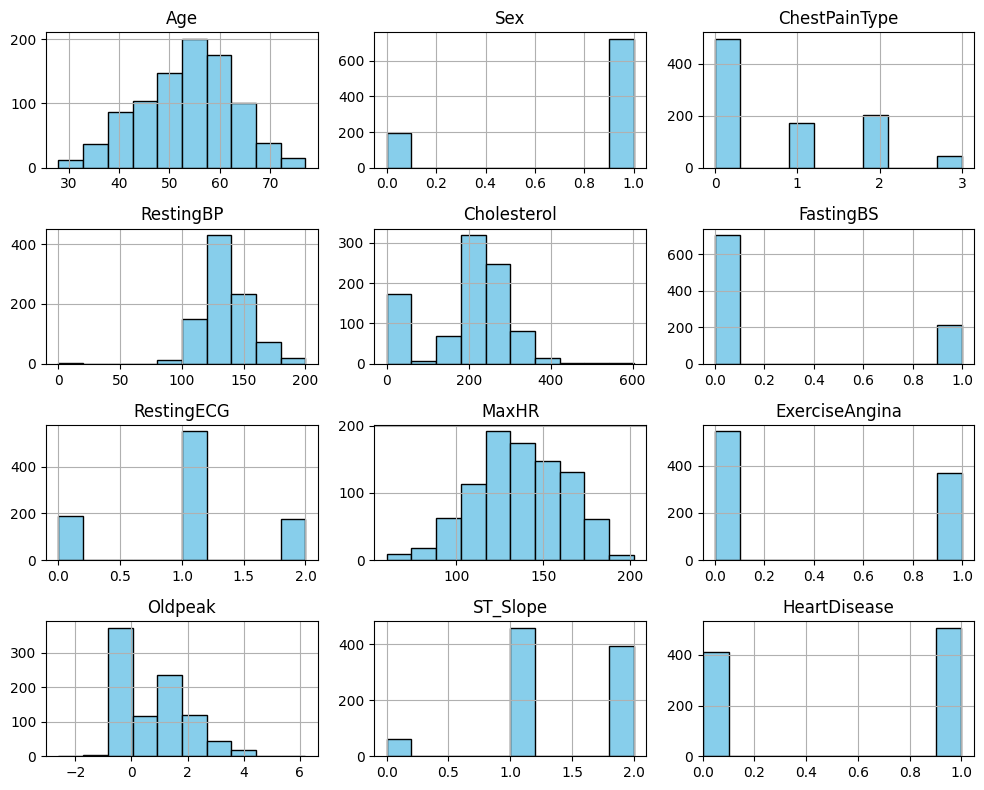

In [12]:
data.hist(figsize=(10, 8), bins=10, color='skyblue', edgecolor='black')
plt.xlim(left=0)
plt.tight_layout()
plt.show()

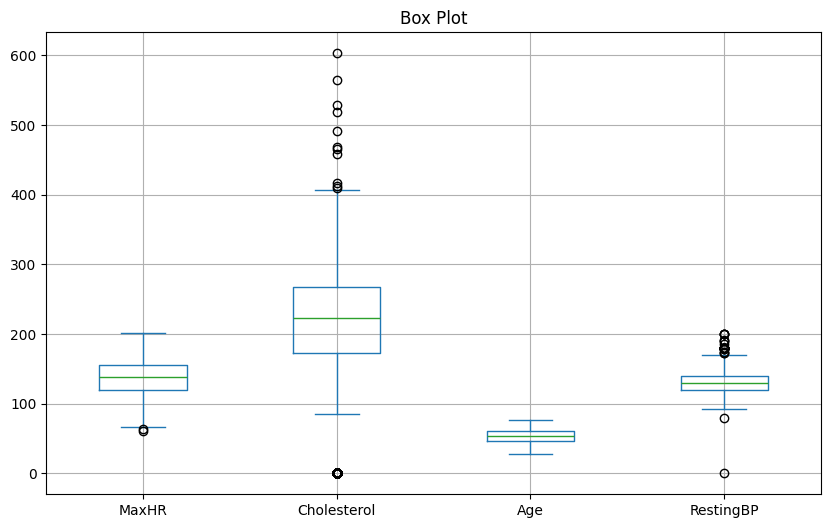

In [13]:
numerical_columns = ['MaxHR', 'Cholesterol', 'Age', 'RestingBP']
data[numerical_columns].plot(kind='box', figsize=(10, 6), grid=True)
plt.title("Box Plot")
plt.show()

In [14]:
# Converting age into bins representing different age groups
data['AgeGroups'] = pd.qcut(data['Age'], q=4, labels=[1, 2, 3, 4])
data.drop(['Age'], axis=1, inplace=True)

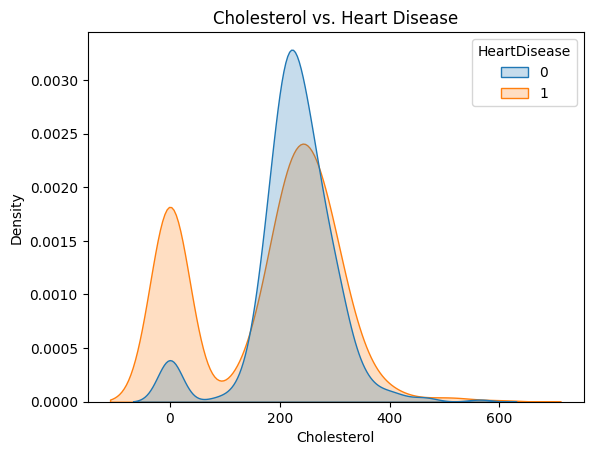

In [15]:
sns.kdeplot(data=data, x="Cholesterol", hue="HeartDisease", fill=True)
plt.title("Cholesterol vs. Heart Disease")
plt.show()

In [16]:
from sklearn.neighbors import KNeighborsRegressor

def knn_impute_cholesterol(X_train, X_val, X_test, n_neighbors=5):
    # Train KNN imputer on training set only
    features = ['Sex', 'ChestPainType', 'RestingBP', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'AgeGroups']

    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn.fit(X_train[X_train['Cholesterol'] != 0][features],
            X_train[X_train['Cholesterol'] != 0]['Cholesterol'])

    # Predict missing cholesterol only in each set
    for dataset in [X_train, X_val, X_test]:
        missing_mask = dataset['Cholesterol'] == 0
        dataset.loc[missing_mask, 'Cholesterol'] = knn.predict(dataset.loc[missing_mask, features])

    return X_train, X_val, X_test

In [17]:
# Replace the zero values in the cholesterol column with values from the distribution of the cholesterol column
def replace_zeros_with_distribution(df, col):
    df_replaced = df.copy()
    nonzero_values = df[col][df[col] != 0]
    if not nonzero_values.empty:
        df_replaced[col] = df[col].apply(lambda x: np.random.choice(nonzero_values) if x == 0 else x)
    return df_replaced

In [18]:
data = data[data['Cholesterol'] != 0]

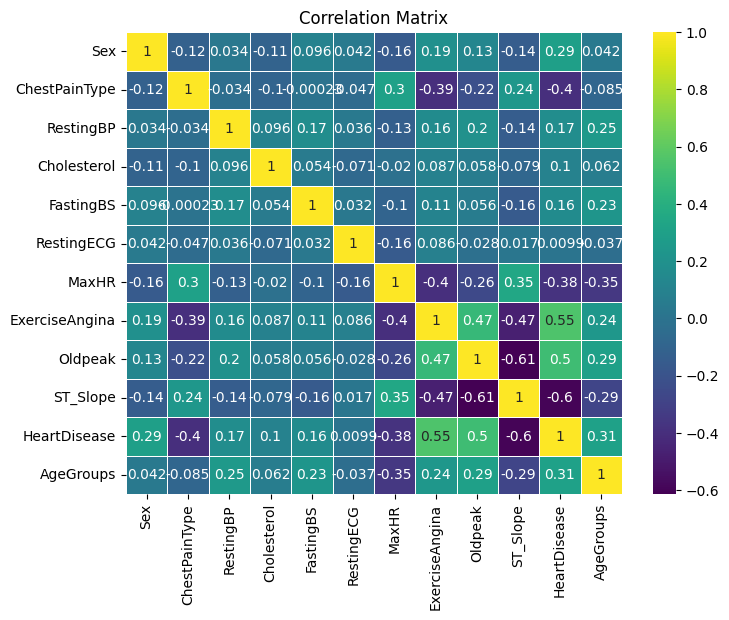

In [19]:
corr_matrix = data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Data Split

In [20]:
data_preprocessed = data.copy()
Y = data.pop('HeartDisease')
data_preprocessed.head()

,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,AgeGroups
0,1,1,140,289,0,1,172,0,0.0,2,0,1
1,0,2,160,180,0,1,156,0,1.0,1,1,2
2,1,1,130,283,0,2,98,0,0.0,2,0,1
3,0,0,138,214,0,1,108,1,1.5,1,1,2
4,1,2,150,195,0,1,122,0,0.0,2,0,2


In [21]:
def split_data(data, Y, scaling=True):
    X_train_val, X_test, y_train_val, y_test = train_test_split(data, Y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

    if scaling:
        # Standardize the data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

    return X_train, X_val, X_test, y_train, y_val, y_test

# ML Model

Accuracy: 0.8533333333333334
              precision    recall  f1-score   support

           0       0.82      0.89      0.85        71
           1       0.89      0.82      0.86        79

    accuracy                           0.85       150
   macro avg       0.85      0.86      0.85       150
weighted avg       0.86      0.85      0.85       150



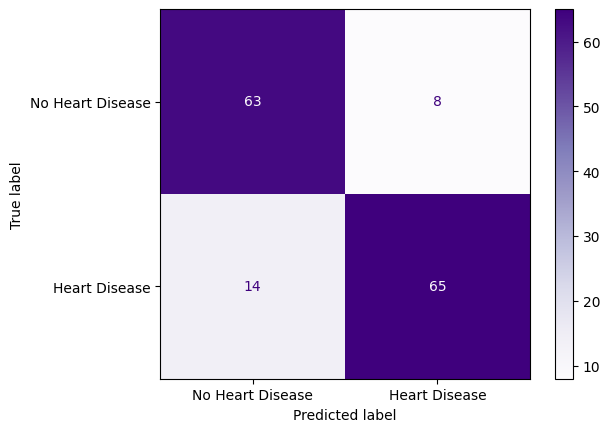

In [22]:
# Split data
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data, Y)
regression_model = LogisticRegression()
regression_model.fit(X_train, y_train)
y_pred_regression = regression_model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_regression))
print(classification_report(y_test, y_pred_regression))
cm_reg= confusion_matrix(y_test, y_pred_regression)
disp_reg = ConfusionMatrixDisplay(confusion_matrix=cm_reg, display_labels=["No Heart Disease", "Heart Disease"])
disp_reg.plot(cmap='Purples')

# Neural Network

In [23]:
# imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from keras import Input
from tensorflow.keras import backend as K

In [24]:
def plot_results(history):
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Plot the losses
    plt.figure(figsize=(8, 6))
    plt.plot(training_loss, label='Training Loss', color='blue', linewidth=2)
    plt.plot(validation_loss, label='Validation Loss', color='orange', linewidth=2)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

In [25]:
def plot_confusion_matrix(model, X_test, y_test, threshold=0.5):
    y_pred_probs = model.predict(X_test)
    prob_pred = (y_pred_probs > threshold).astype(int)
    cm = confusion_matrix(y_test, prob_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Heart Disease", "Heart Disease"])
    disp.plot(cmap="Blues", values_format='d')
    plt.title(f"Confusion Matrix")
    plt.xticks(rotation=45)
    plt.show()

In [26]:
def create_model(num_neurons, activation_func_name, learning_rate, X_train, X_val, X_test, y_train, y_val, y_test):
    K.clear_session()
    # Define model
    model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Use Input layer instead of input_shape in Dense
    Dense(num_neurons, activation=activation_func_name),
    Dense(1, activation='sigmoid')
    ])
    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy'])
    # Train model
    history = model.fit(X_train, y_train,
                  validation_data=(X_val, y_val),
                  epochs=50, batch_size=32)
    # Evaluate
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    plot_results(history)
    plot_confusion_matrix(model, X_test, y_test)

### Basic Network

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.2779 - loss: 1.0712 - val_accuracy: 0.3356 - val_loss: 0.9088
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3912 - loss: 0.8729 - val_accuracy: 0.4832 - val_loss: 0.7564
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5064 - loss: 0.7549 - val_accuracy: 0.6510 - val_loss: 0.6453
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6244 - loss: 0.6665 - val_accuracy: 0.7517 - val_loss: 0.5662
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7255 - loss: 0.5653 - val_accuracy: 0.7651 - val_loss: 0.5146
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7269 - loss: 0.5293 - val_accuracy: 0.7852 - val_loss: 0.4790
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7742 - loss: 0.5059 - val_accuracy: 0.7987 - val_loss: 0.4551
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7972 - loss: 0.4698 - val_accuracy: 0.8188 - val_lo

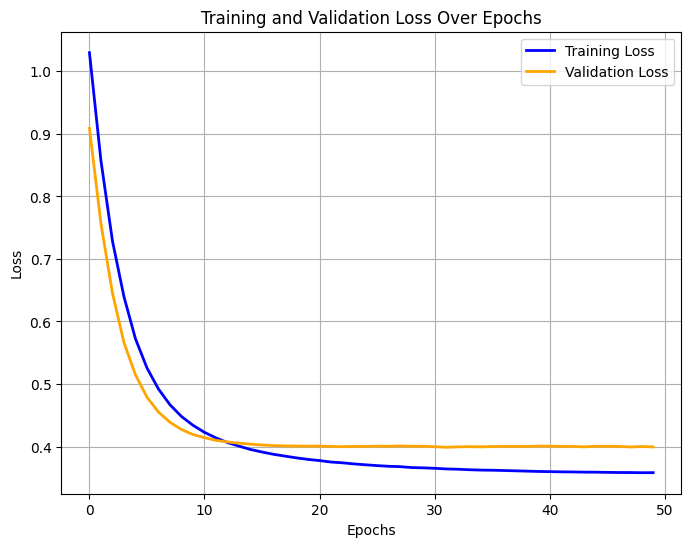

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


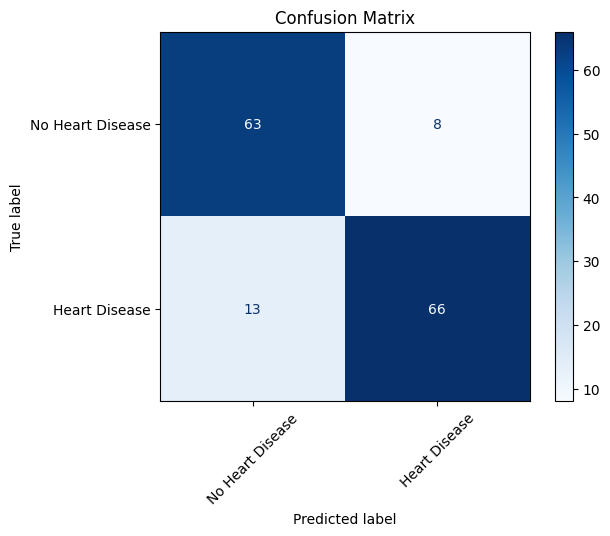

In [27]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data, Y)
# Definition & train
create_model(16, None, 0.001, X_train, X_val, X_test, y_train, y_val, y_test)

# Experiments with Hyperparameter

## Hyperparameter - Learning Rate

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7259 - loss: 0.5871 - val_accuracy: 0.8054 - val_loss: 0.4518
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8253 - loss: 0.4036 - val_accuracy: 0.8188 - val_loss: 0.4004
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8436 - loss: 0.3744 - val_accuracy: 0.8456 - val_loss: 0.4016
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8416 - loss: 0.3717 - val_accuracy: 0.8322 - val_loss: 0.4013
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8306 - loss: 0.3992 - val_accuracy: 0.8523 - val_loss: 0.4191
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8254 - loss: 0.3952 - val_accuracy: 0.8255 - val_loss: 0.4945
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8240 - loss: 0.4521 - val_accuracy: 0.8456 - val_loss: 0.4305
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8541 - loss: 0.3524 - val_accuracy: 0.8389 - val_l

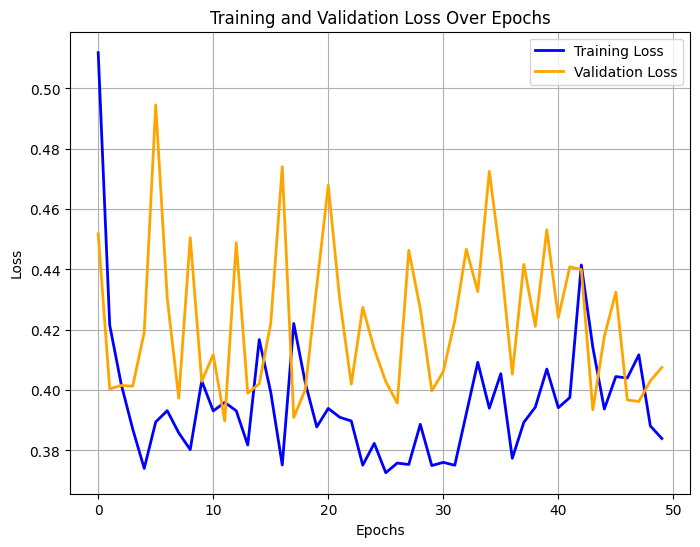

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


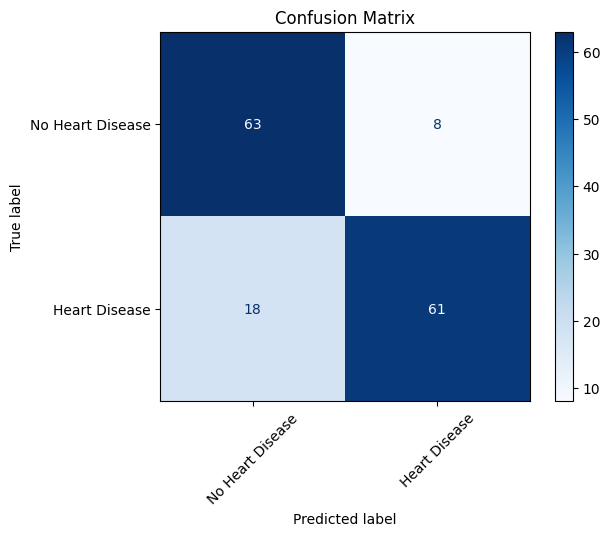

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7924 - loss: 0.4993 - val_accuracy: 0.8456 - val_loss: 0.4128
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8492 - loss: 0.3685 - val_accuracy: 0.8322 - val_loss: 0.4079
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8631 - loss: 0.3303 - val_accuracy: 0.8389 - val_loss: 0.4043
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8463 - loss: 0.3387 - val_accuracy: 0.8389 - val_loss: 0.4039
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8644 - loss: 0.3247 - val_accuracy: 0.8456 - val_loss: 0.4021
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8497 - loss: 0.3402 - val_accuracy: 0.8456 - val_loss: 0.3967
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8092 - loss: 0.4042 - val_accuracy: 0.8456 - val_loss: 0.3918
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8292 - loss: 0.3887 - val_accuracy: 0.8523 - val_los

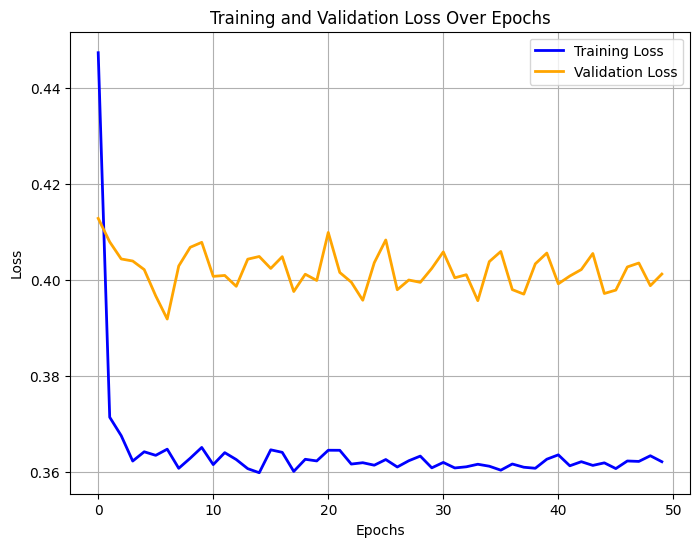

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


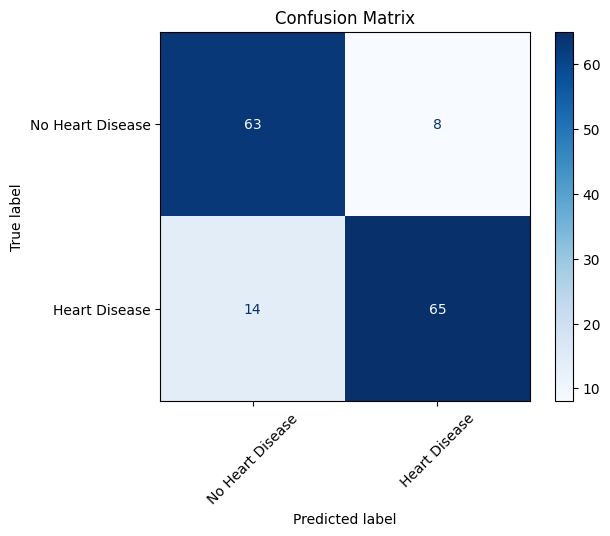

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.6177 - loss: 0.6611 - val_accuracy: 0.7248 - val_loss: 0.5707
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7108 - loss: 0.5723 - val_accuracy: 0.7517 - val_loss: 0.5157
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7276 - loss: 0.5411 - val_accuracy: 0.7919 - val_loss: 0.4779
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7730 - loss: 0.5086 - val_accuracy: 0.8121 - val_loss: 0.4515
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7815 - loss: 0.4561 - val_accuracy: 0.8255 - val_loss: 0.4325
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8167 - loss: 0.4394 - val_accuracy: 0.8255 - val_loss: 0.4201
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8458 - loss: 0.4109 - val_accuracy: 0.8322 - val_loss: 0.4120
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8576 - loss: 0.3720 - val_accuracy: 0.8389 - val_

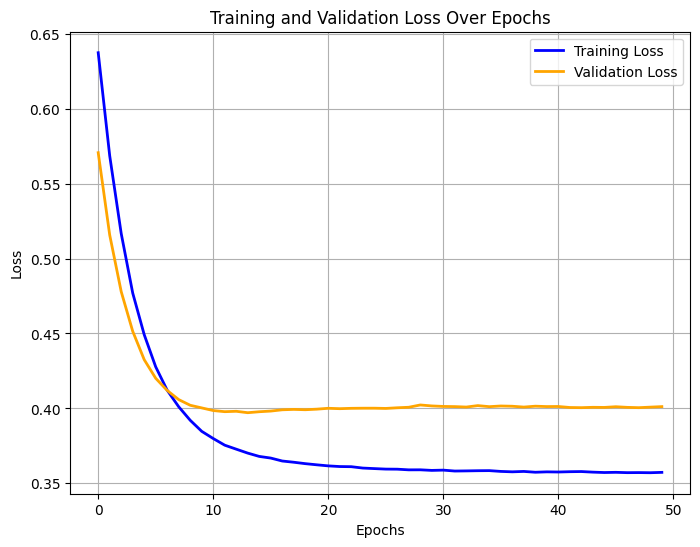

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


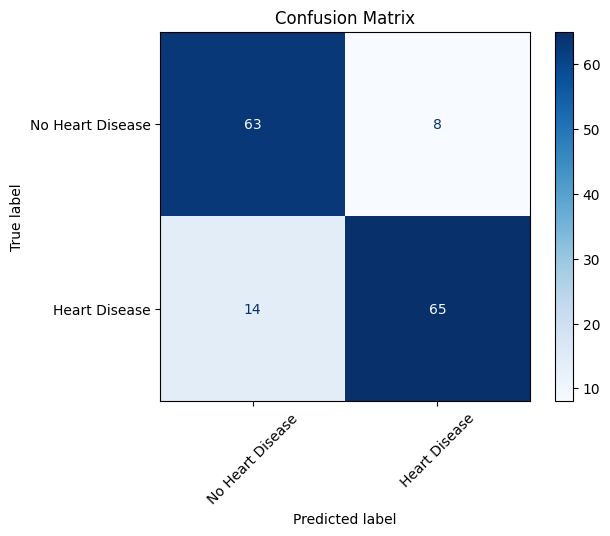

In [28]:
create_model(num_neurons=16, activation_func_name=None, learning_rate=0.1, X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test)
create_model(num_neurons=16, activation_func_name=None, learning_rate=0.01, X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test)
create_model(num_neurons=16, activation_func_name=None, learning_rate=0.001, X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test)

## Hyperparameter - Number of Neurons

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5719 - loss: 0.9014 - val_accuracy: 0.6577 - val_loss: 0.6957
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6265 - loss: 0.7724 - val_accuracy: 0.6980 - val_loss: 0.6496
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6453 - loss: 0.7624 - val_accuracy: 0.7383 - val_loss: 0.6118
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6864 - loss: 0.6821 - val_accuracy: 0.7450 - val_loss: 0.5807
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6818 - loss: 0.7014 - val_accuracy: 0.7651 - val_loss: 0.5546
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7573 - loss: 0.5543 - val_accuracy: 0.7718 - val_loss: 0.5345
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7474 - loss: 0.5544 - val_accuracy: 0.7718 - val_loss: 0.5179
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7821 - loss: 0.5496 - val_accuracy: 0.7718 - val_los

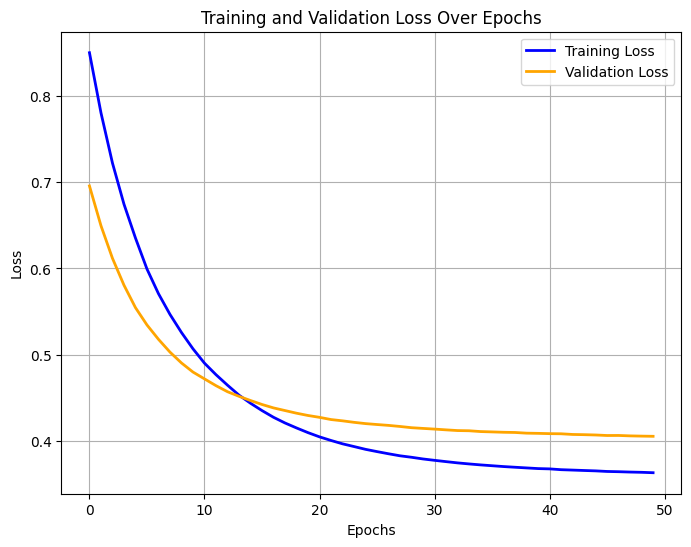

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


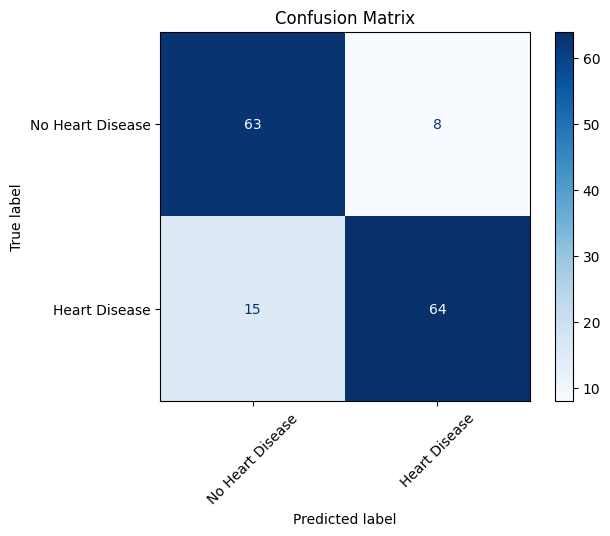

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6730 - loss: 0.6687 - val_accuracy: 0.6980 - val_loss: 0.6199
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7161 - loss: 0.6283 - val_accuracy: 0.7383 - val_loss: 0.5627
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7245 - loss: 0.6121 - val_accuracy: 0.7651 - val_loss: 0.5248
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7339 - loss: 0.5798 - val_accuracy: 0.7785 - val_loss: 0.4990
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7914 - loss: 0.4954 - val_accuracy: 0.7785 - val_loss: 0.4809
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7967 - loss: 0.4911 - val_accuracy: 0.7987 - val_loss: 0.4668
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8131 - loss: 0.4188 - val_accuracy: 0.7987 - val_loss: 0.4562
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7761 - loss: 0.5018 - val_accuracy: 0.7987 - val

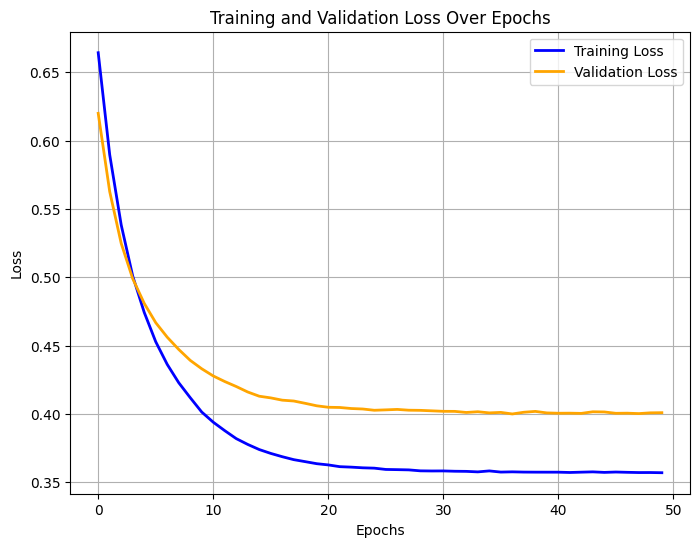

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


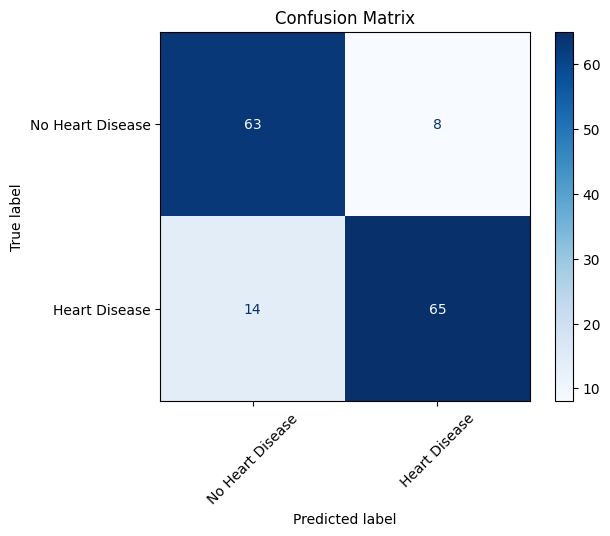

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6855 - loss: 0.6000 - val_accuracy: 0.8322 - val_loss: 0.4622
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8248 - loss: 0.4240 - val_accuracy: 0.8456 - val_loss: 0.4138
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8190 - loss: 0.4132 - val_accuracy: 0.8322 - val_loss: 0.4056
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8283 - loss: 0.4179 - val_accuracy: 0.8322 - val_loss: 0.4044
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8484 - loss: 0.3433 - val_accuracy: 0.8255 - val_loss: 0.4037
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8316 - loss: 0.3762 - val_accuracy: 0.8255 - val_loss: 0.4039
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8626 - loss: 0.3328 - val_accuracy: 0.8322 - val_loss: 0.4028
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8813 - loss: 0.3331 - val_accuracy: 0.8322 - val_los

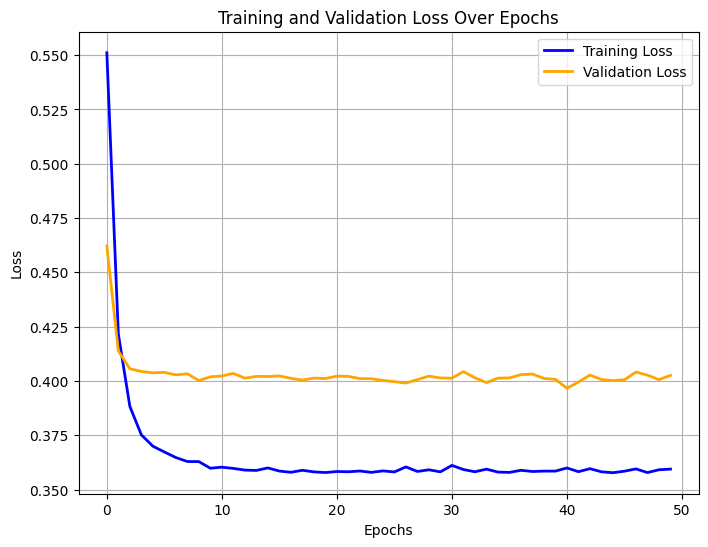

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


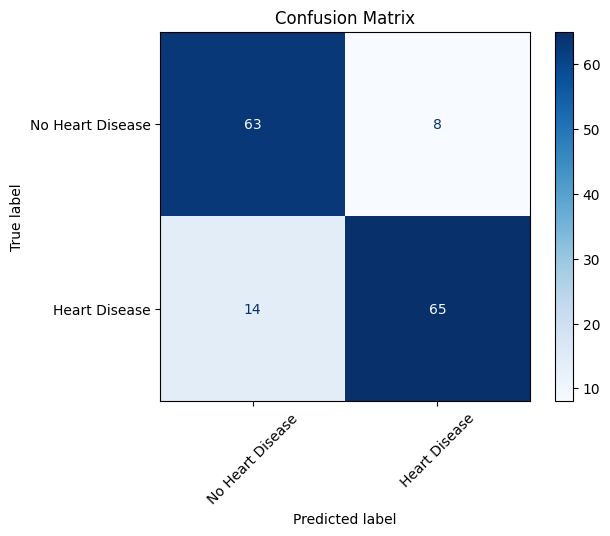

In [29]:
create_model(num_neurons=4, activation_func_name=None, learning_rate=0.001, X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test)
create_model(num_neurons=16, activation_func_name=None, learning_rate=0.001, X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test)
create_model(num_neurons=100, activation_func_name=None, learning_rate=0.001, X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test)

## Hyperparameter - Activation Function

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6262 - loss: 0.7344 - val_accuracy: 0.6913 - val_loss: 0.6360
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6676 - loss: 0.6433 - val_accuracy: 0.7651 - val_loss: 0.5594
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7343 - loss: 0.5540 - val_accuracy: 0.7852 - val_loss: 0.5048
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7561 - loss: 0.5472 - val_accuracy: 0.8054 - val_loss: 0.4683
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7844 - loss: 0.4686 - val_accuracy: 0.8188 - val_loss: 0.4421
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7928 - loss: 0.4726 - val_accuracy: 0.8188 - val_loss: 0.4239
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8130 - loss: 0.4325 - val_accuracy: 0.8389 - val_loss: 0.4116
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8204 - loss: 0.4427 - val_accuracy: 0.8322 - val_loss

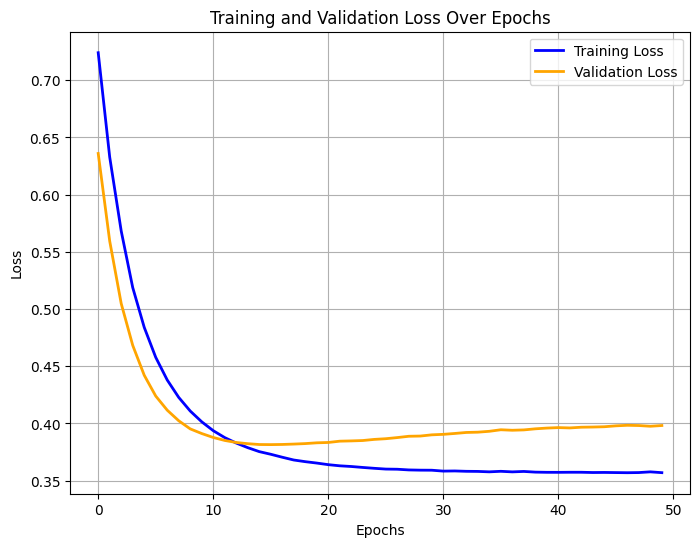

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


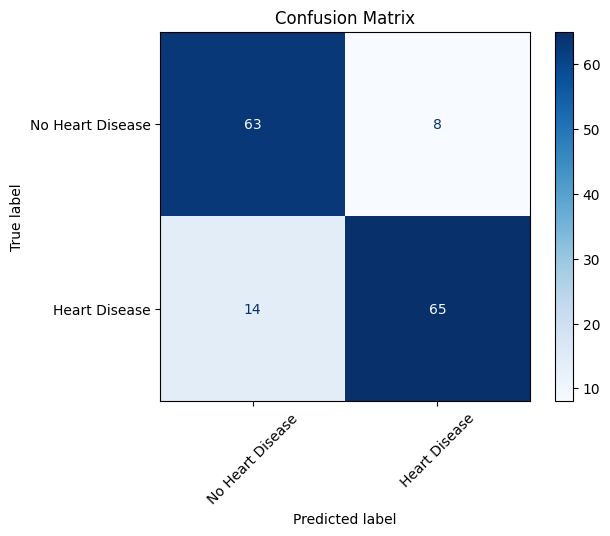

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5102 - loss: 0.8033 - val_accuracy: 0.5302 - val_loss: 0.7407
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5612 - loss: 0.7721 - val_accuracy: 0.5705 - val_loss: 0.6784
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6096 - loss: 0.6980 - val_accuracy: 0.6107 - val_loss: 0.6280
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6602 - loss: 0.6450 - val_accuracy: 0.6913 - val_loss: 0.5879
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6984 - loss: 0.5820 - val_accuracy: 0.7450 - val_loss: 0.5547
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6848 - loss: 0.5734 - val_accuracy: 0.7919 - val_loss: 0.5279
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6851 - loss: 0.5585 - val_accuracy: 0.8054 - val_loss: 0.5060
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7794 - loss: 0.4801 - val_accuracy: 0.8188 - val_l

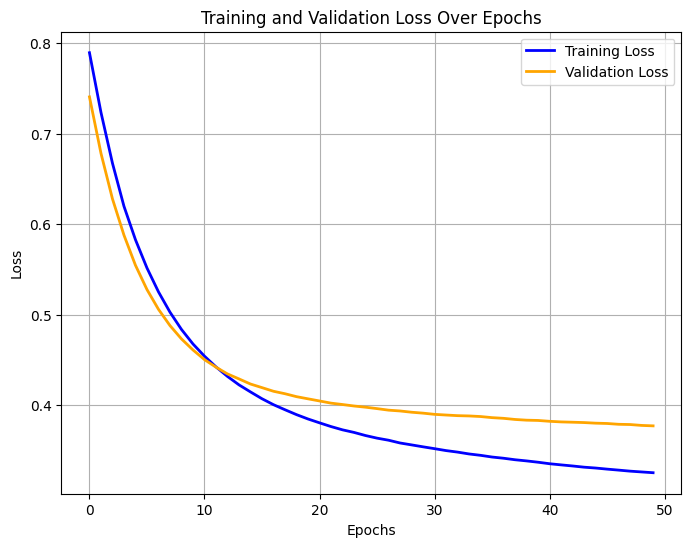

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


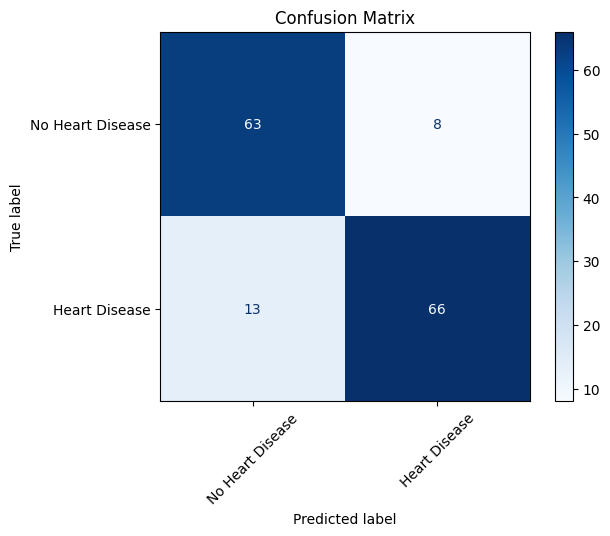

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3383 - loss: 0.8959 - val_accuracy: 0.3691 - val_loss: 0.8069
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4158 - loss: 0.7833 - val_accuracy: 0.5034 - val_loss: 0.7192
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4993 - loss: 0.7077 - val_accuracy: 0.6443 - val_loss: 0.6484
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6233 - loss: 0.6448 - val_accuracy: 0.7383 - val_loss: 0.5922
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7092 - loss: 0.5849 - val_accuracy: 0.7584 - val_loss: 0.5485
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7746 - loss: 0.5259 - val_accuracy: 0.7785 - val_loss: 0.5144
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7746 - loss: 0.5097 - val_accuracy: 0.8121 - val_loss: 0.4870
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7866 - loss: 0.4837 - val_accuracy: 0.8255 - val_los

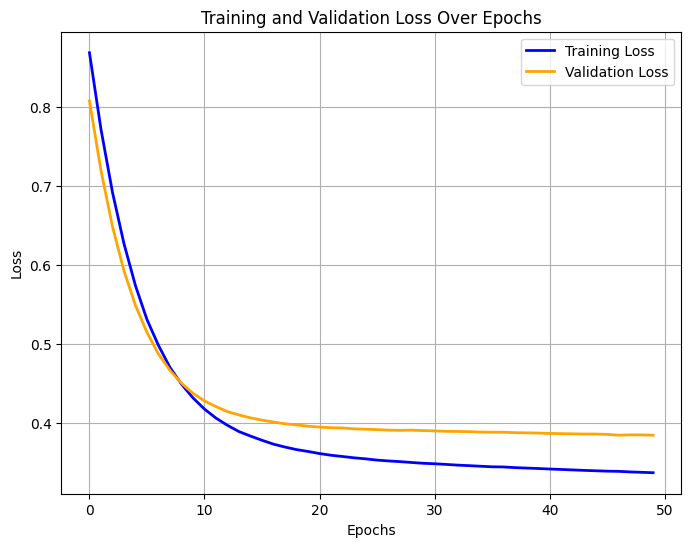

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


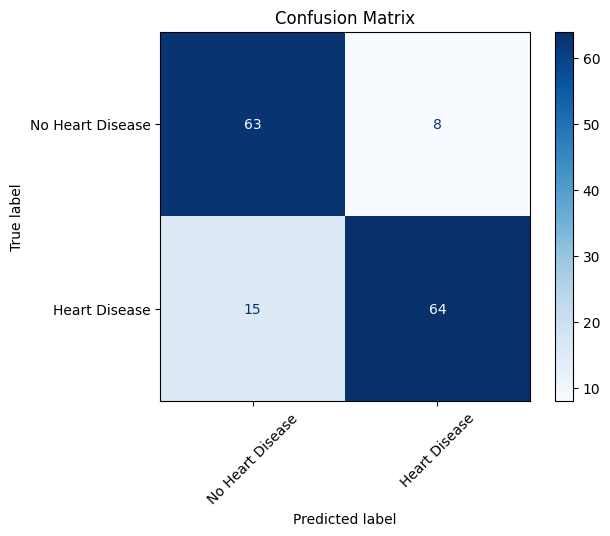

In [30]:
create_model(num_neurons=16, activation_func_name=None, learning_rate=0.001, X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test)
create_model(num_neurons=16, activation_func_name='relu', learning_rate=0.001, X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test)
create_model(num_neurons=16, activation_func_name='tanh', learning_rate=0.001, X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test)

# Data Modifications Scenarios

## Improved Data Scenario

In [31]:
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)  # First quartile
        Q3 = df[col].quantile(0.75)  # Third quartile
        IQR = Q3 - Q1               # Interquartile range
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

In [32]:
def balance_classes(df, column_name):
    min_count = df[column_name].value_counts().min()
    balanced_df = pd.concat([
        df[df[column_name] == val].sample(min_count, random_state=42)
        for val in df[column_name].unique()
    ])
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    print(balanced_df[column_name].value_counts())
    return balanced_df

HeartDisease
1    356
0    356
Name: count, dtype: int64
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5937 - loss: 0.7492 - val_accuracy: 0.5746 - val_loss: 0.8085
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6647 - loss: 0.6566 - val_accuracy: 0.6343 - val_loss: 0.7415
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6630 - loss: 0.6643 - val_accuracy: 0.6791 - val_loss: 0.6865
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6907 - loss: 0.6066 - val_accuracy: 0.7090 - val_loss: 0.6430
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7492 - loss: 0.5481 - val_accuracy: 0.7537 - val_loss: 0.6036
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7283 - loss: 0.5383 - val_accuracy: 0.7761 - val_loss: 0.5694
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7730 - loss: 0.5084 - val_accuracy: 0.7985 - val_loss: 0.5426
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accurac

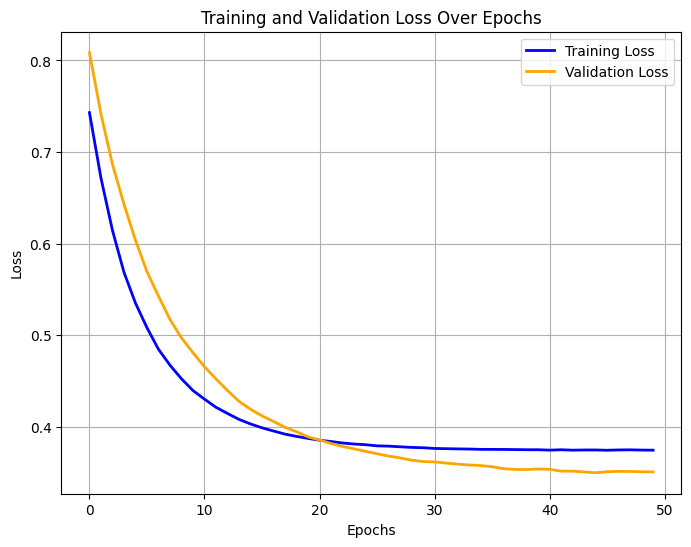

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


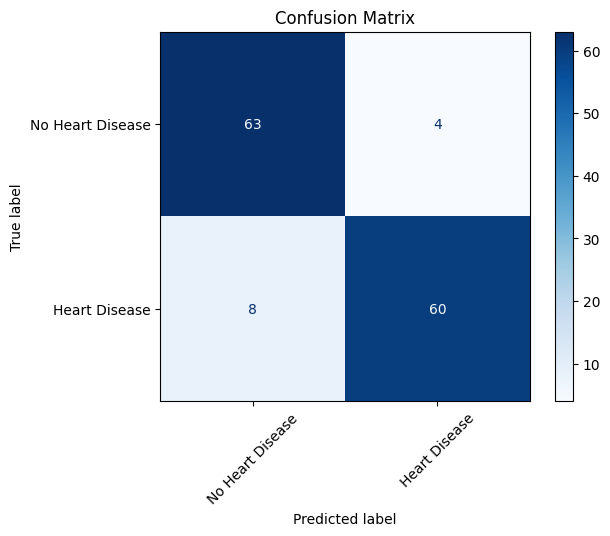

In [33]:
# Reloading data
data_improved = data_preprocessed.copy()
# Additional pre-process
balanced_data_improved = balance_classes(data_improved, 'HeartDisease')
data_improved_without_outliers = remove_outliers(balanced_data_improved, ['Cholesterol', 'RestingBP', 'MaxHR'])
Y_improved = data_improved_without_outliers.pop("HeartDisease")
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data_improved_without_outliers, Y_improved)
create_model(16, None, 0.001, X_train, X_val, X_test, y_train, y_val, y_test)

## Bad Data Scenario

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2421 - loss: 1.5569 - val_accuracy: 0.3154 - val_loss: 1.3727
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2594 - loss: 1.3148 - val_accuracy: 0.3624 - val_loss: 1.2117
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2503 - loss: 1.2068 - val_accuracy: 0.3826 - val_loss: 1.0678
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3135 - loss: 1.0271 - val_accuracy: 0.4295 - val_loss: 0.9459
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3984 - loss: 0.9154 - val_accuracy: 0.5034 - val_loss: 0.8451
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5175 - loss: 0.8143 - val_accuracy: 0.5638 - val_loss: 0.7626
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5698 - loss: 0.7541 - val_accuracy: 0.6242 - val_loss: 0.6943
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6393 - loss: 0.6731 - val_accuracy: 0.6376 - val_loss

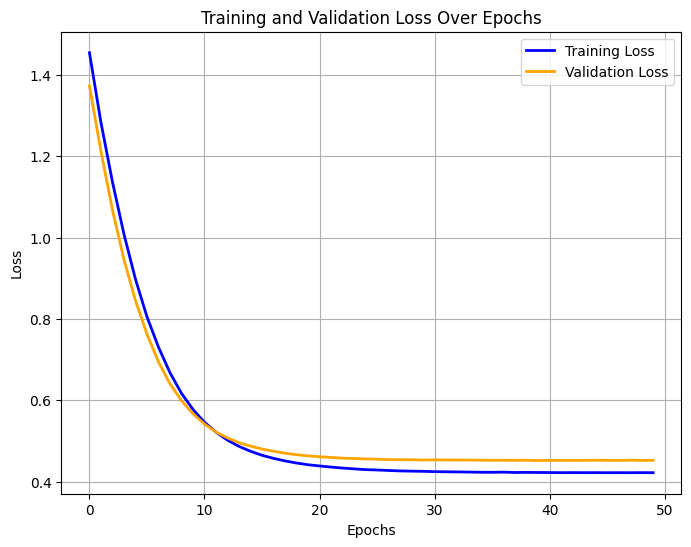

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


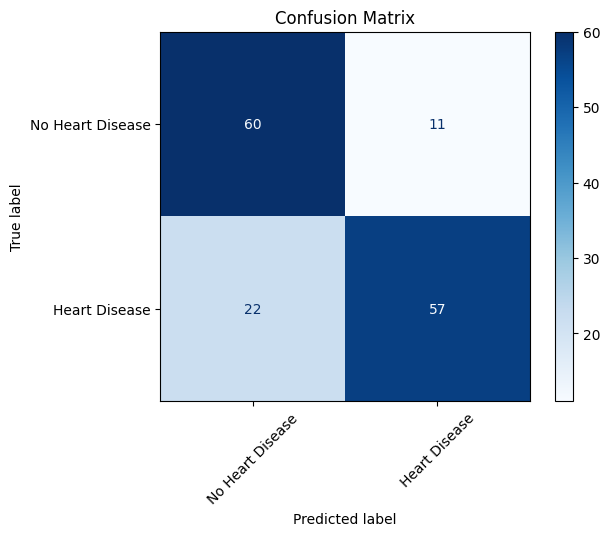

In [34]:
data_bad = data_preprocessed.copy()
data_bad.drop(["ST_Slope", "ChestPainType"], axis=1, inplace=True)
Y_bad = data_bad.pop("HeartDisease")
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data_bad, Y_bad)
create_model(16, None, 0.001, X_train, X_val, X_test, y_train, y_val, y_test)

# Improving Model Architecture

In [35]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, BatchNormalization
def create_improved_model(num_neurons, activation_func_name, learning_rate, X_train, X_val, X_test, y_train, y_val, y_test):
    K.clear_session()
    # Define model
    model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Use Input layer instead of input_shape in Dense
    Dense(num_neurons, activation=activation_func_name),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
    ])
    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate, weight_decay=0.01),
            loss='binary_crossentropy',
            metrics=['accuracy'])
    # Train model
    history = model.fit(X_train, y_train,
                  validation_data=(X_val, y_val),
                  epochs=40, batch_size=64)
    # Evaluate
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    plot_results(history)
    plot_confusion_matrix(model, X_test, y_test)

Epoch 1/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.3798 - loss: 1.0645 - val_accuracy: 0.6376 - val_loss: 0.6596
Epoch 2/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6376 - loss: 0.6403 - val_accuracy: 0.7852 - val_loss: 0.5946
Epoch 3/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8444 - loss: 0.4356 - val_accuracy: 0.8054 - val_loss: 0.5484
Epoch 4/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8417 - loss: 0.3886 - val_accuracy: 0.8121 - val_loss: 0.5227
Epoch 5/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8260 - loss: 0.3820 - val_accuracy: 0.8322 - val_loss: 0.5026
Epoch 6/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8278 - loss: 0.3893 - val_accuracy: 0.8322 - val_loss: 0.4943
Epoch 7/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8689 - loss: 0.3215 - val_accuracy: 0.8322 - val_loss: 0.4850
Epoch 8/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8295 - loss: 0.3799 - val_accuracy: 0.8322 - val_loss: 0.4835

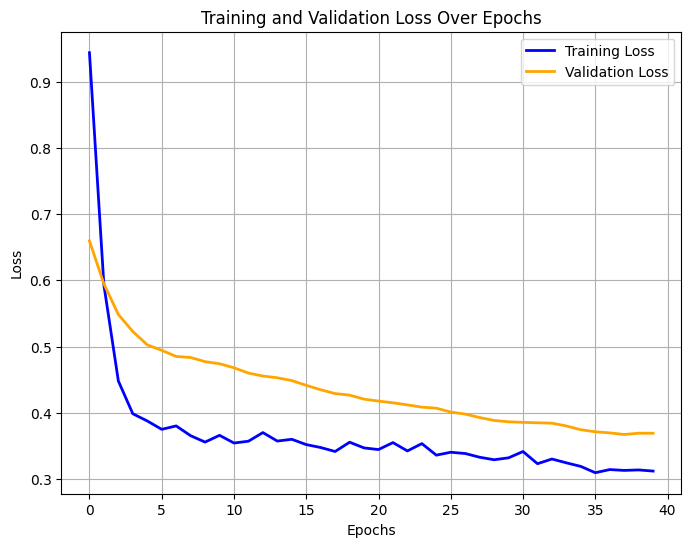

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


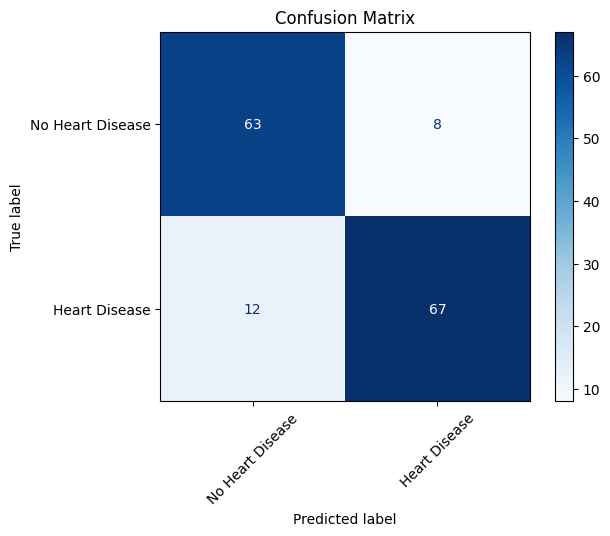

In [46]:
data_new = data_preprocessed.copy()
Y_new = data_new.pop("HeartDisease")
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data_new, Y_new)
create_improved_model(12, 'sigmoid', 0.01, X_train, X_val, X_test, y_train, y_val, y_test)

# New Metric

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt
import numpy as np

# Custom callback to track MCC
class MCCCallback(Callback):
    def __init__(self, X_val, y_val):
        self.X_val = X_val
        self.y_val = y_val
        self.mcc_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred_probs = self.model.predict(self.X_val)
        y_pred = (y_pred_probs > 0.5).astype(int)
        mcc = matthews_corrcoef(self.y_val, y_pred)
        self.mcc_scores.append(mcc)
        print(f"Epoch {epoch+1}: MCC = {mcc:.4f}")

def nn_newMatric(neurons, func, learning_rate, X_train, X_val, X_test, y_train, y_val, y_test):
    K.clear_session()
    model = Sequential([
        Dense(neurons, activation=func, input_shape=(X_train.shape[1],)),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Initialize MCC tracking
    mcc_callback = MCCCallback(X_val, y_val)

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=80, batch_size=32,
                        callbacks=[mcc_callback])  # Track MCC after each epoch

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Extract loss values from the history object
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

     # Plot MCC over epochs
    plt.figure(figsize=(8, 6))
    plt.plot(mcc_callback.mcc_scores, label='MCC Score', color='green', linewidth=2)
    plt.xlabel('Epochs')
    plt.ylabel('MCC')
    plt.title('MCC Score Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Predictions
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int)

    # Compute final MCC
    final_mcc = matthews_corrcoef(y_test, y_pred)
    print(f"Final MCC: {final_mcc:.4f}")

Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1: MCC = 0.2036
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5125 - loss: 0.7218 - val_accuracy: 0.5503 - val_loss: 0.6692
Epoch 2/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 2: MCC = 0.3385
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5328 - loss: 0.6559 - val_accuracy: 0.6309 - val_loss: 0.6267
Epoch 3/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 3: MCC = 0.4906
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6218 - loss: 0.6301 - val_accuracy: 0.7315 - val_loss: 0.5914
Epoch 4/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 4: MCC = 0.5605
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7434 - loss: 0.5695 - val_accuracy: 0.7785 - val_loss: 0.5599
Epoch 5/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 5: MCC = 0.5574
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7985 - loss: 0.5522 - val_accuracy: 0.7785 - val_loss: 0.5321
Epoch 6/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 6: MCC = 0.5703
14/14

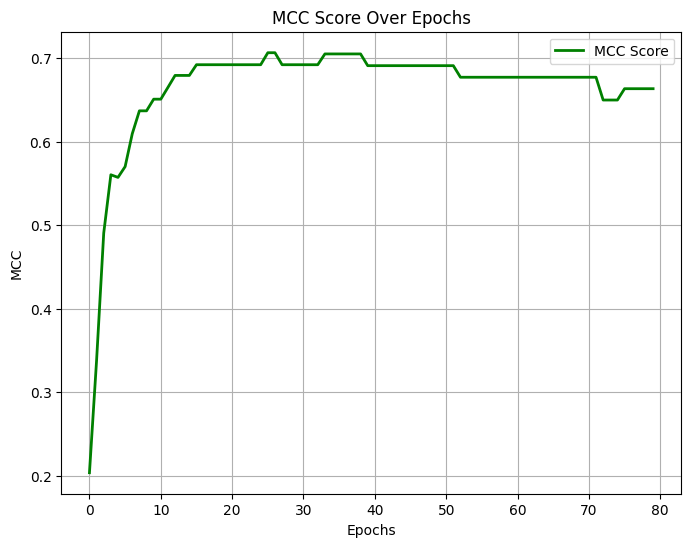

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Final MCC: 0.6848


In [38]:
data_new = data_preprocessed.copy()
Y_new = data_new.pop("HeartDisease")
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data_new, Y_new)
nn_newMatric(16, 'relu', 0.001, X_train, X_val, X_test, y_train, y_val, y_test)

# Unbalanced Data

In [ ]:
import pandas as pd
from sklearn.utils import resample

cp_data = data_preprocessed.copy()
# Check the distribution of ChestPainType before balancing
print("Original Class Distribution:\n", cp_data["ChestPainType"].value_counts())

# Separate the dataset by ChestPainType category
df_0 = cp_data[cp_data["ChestPainType"] == 0]  # Most common class
df_1 = cp_data[cp_data["ChestPainType"] == 1]
df_2 = cp_data[cp_data["ChestPainType"] == 2]
df_3 = cp_data[cp_data["ChestPainType"] == 3]  # Least common class


max_size = df_0.shape[0]  # Majority class size
moderate_size = int(max_size * 0.7)  # Moderately balanced target size
full_size = max_size  # Fully balanced target size

df_1_moderate = resample(df_1, replace=True, n_samples=moderate_size, random_state=42)
df_2_moderate = resample(df_2, replace=True, n_samples=moderate_size, random_state=42)
df_3_moderate = resample(df_3, replace=True, n_samples=moderate_size, random_state=42)

# Combine the moderately balanced dataset
data_moderate = pd.concat([df_0, df_1_moderate, df_2_moderate, df_3_moderate])

df_1_full = resample(df_1, replace=True, n_samples=full_size, random_state=42)
df_2_full = resample(df_2, replace=True, n_samples=full_size, random_state=42)
df_3_full = resample(df_3, replace=True, n_samples=full_size, random_state=42)

# Combine the fully balanced dataset
data_full = pd.concat([df_0, df_1_full, df_2_full, df_3_full])

# Save the balanced datasets
cp_data.to_csv("unbalanced_cp_data.csv", index=False)
data_moderate.to_csv("moderate_balanced_cp_data.csv", index=False)
data_full.to_csv("full_balanced_cp_data.csv", index=False)

print("Moderate and Fully Balanced datasets created successfully!")

In [ ]:
#Run the nural network on unbalanced data
data_new = data_preprocessed.copy()
Y_new = data_new.pop("HeartDisease")
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data_new, Y_new)
create_model(16, None, 0.001, X_train, X_val, X_test, y_train, y_val, y_test)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4434 - loss: 0.8337 - val_accuracy: 0.5043 - val_loss: 0.7364
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5594 - loss: 0.6941 - val_accuracy: 0.6304 - val_loss: 0.6168
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7189 - loss: 0.5627 - val_accuracy: 0.6870 - val_loss: 0.5399
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7571 - loss: 0.5099 - val_accuracy: 0.7696 - val_loss: 0.4918
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7943 - loss: 0.4733 - val_accuracy: 0.8000 - val_loss: 0.4607
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8308 - loss: 0.4399 - val_accuracy: 0.8130 - val_loss: 0.4412
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8468 - loss: 0.4217 - val_accuracy: 0.8304 - val_loss: 0.4293
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8276 - loss: 0.4396 - val_accuracy: 0.8348 - val_loss

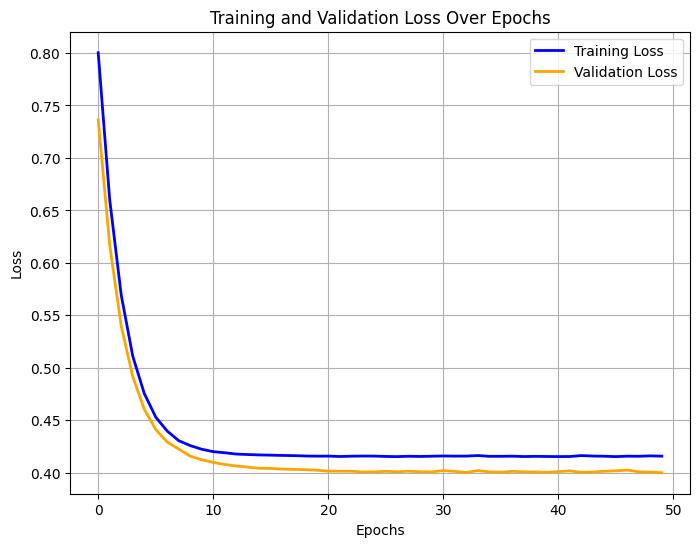

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


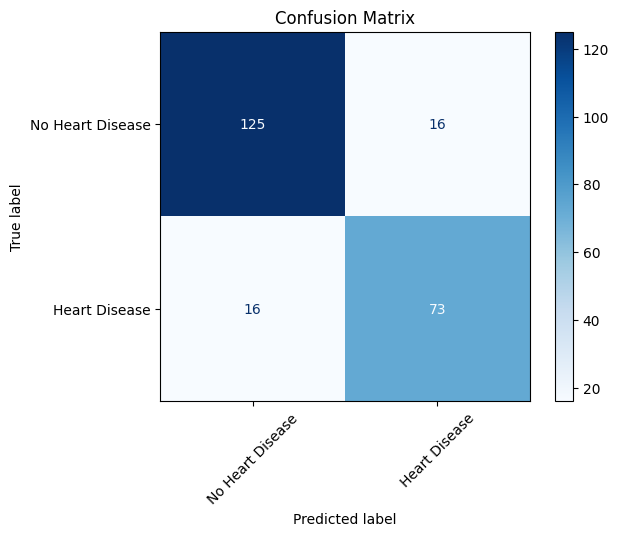

In [41]:
#Run the nural network on moderate balanced data
Y_new = data_moderate.pop("HeartDisease")
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data_moderate, Y_new)
create_model(16, None, 0.001, X_train, X_val, X_test, y_train, y_val, y_test)

In [ ]:
#Run the nural network on fully balanced data
Y_new = data_full.pop("HeartDisease")
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data_full, Y_new)
create_model(16, None, 0.001, X_train, X_val, X_test, y_train, y_val, y_test)

# PCA

In [ ]:
from sklearn.decomposition import PCA

data_for_pca = data_preprocessed.copy()
Y_pca = data_for_pca.pop("HeartDisease")
# Splitting data
X_train_val, X_test, y_train_val, y_test = train_test_split(data, Y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
# Scaling data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
# Performing PCA
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_scaled)  # Fit and transform training data
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)
print("Explained Variance Ratio: ", pca.explained_variance_ratio_)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.3591 - loss: 0.9404 - val_accuracy: 0.4497 - val_loss: 0.8544
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4650 - loss: 0.7889 - val_accuracy: 0.5302 - val_loss: 0.7565
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5551 - loss: 0.7201 - val_accuracy: 0.6376 - val_loss: 0.6737
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6312 - loss: 0.6420 - val_accuracy: 0.7181 - val_loss: 0.6078
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7438 - loss: 0.5754 - val_accuracy: 0.7785 - val_loss: 0.5577
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8280 - loss: 0.5127 - val_accuracy: 0.8054 - val_loss: 0.5192
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8301 - loss: 0.5031 - val_accuracy: 0.8255 - val_loss: 0.4897
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8461 - loss: 0.4759 - val_accuracy: 0.8389 - val_los

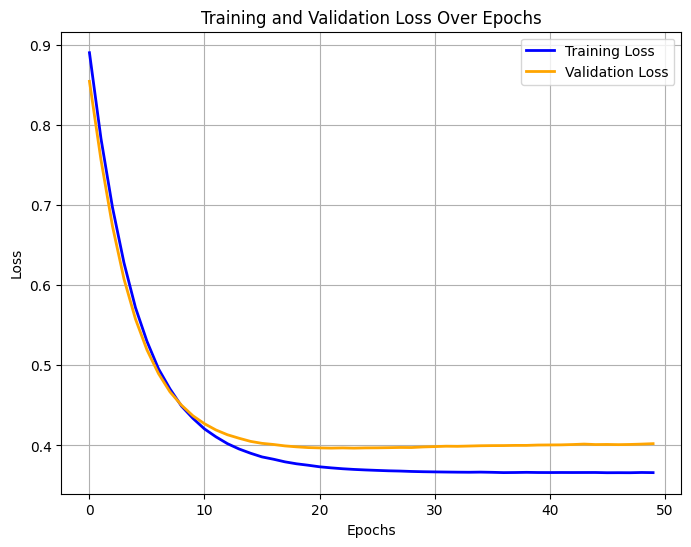

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


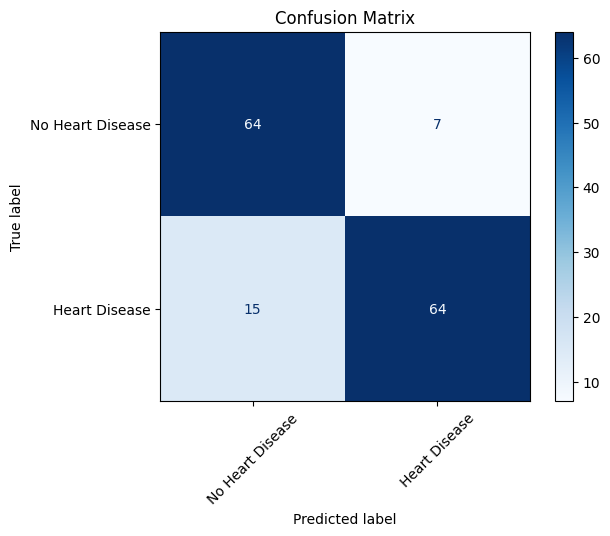

In [44]:
create_model(16, None, 0.001, X_train_pca, X_val_pca, X_test_pca, y_train, y_val, y_test)

# The End